# Image Based Visual Serviong(IBVS) via DL-Clip and DL-Online

Implementing the IBVS algorithm through DL-Clip and DL-Online, this notebook contains everything from data sampling, feature extraction neural network training, initial controller training, to iterative policy updates, and the comparison of the effect of DL-Clip and DL-Online is carried out.

## Import libraries

Before running, please `pip install -r requirements.txt`

In [42]:
# import imp
import time
import subprocess
import os
import sys
import json

import socket
import pygetwindow as gw

import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import pickle
from tqdm import trange


from matplotlib import rcParams
# config = {
#         "font.family":'Times New Roman',
#         "font.size": 10,
# }

# rcParams.update(config)

os.environ['KMP_DUPLICATE_LIB_OK']='True'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # cuda or cpu
print(device)

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

cuda


In [43]:
def send_to_window(window_title, text):
    '''
    Close the window by `pygetwindow` library.
    '''
    cmd_window = gw.getWindowsWithTitle(window_title)
    if not cmd_window:
        print(f"Window with title '{window_title}' not found.")
        return
    
    for window in cmd_window:
        window.close()

In [44]:
def HIL_disconnect():
    '''
    Exit RflySim simulation experiments by `taskkill` cmd, and close the window by `pygetwindow` library.
    '''
    time.sleep(1)
    print('Exit hardware in the loop simulation software')
    window_title = "RflySimStart" 
    
    os.system('tasklist|find /i "CopterSim.exe" && taskkill /im "CopterSim.exe"')
    os.system('tasklist|find /i "QGroundControl.exe" && taskkill /f /im "QGroundControl.exe"')
    os.system('tasklist|find /i "RflySim3D.exe" && taskkill /f /im "RflySim3D.exe"')
    time.sleep(1)
    send_to_window(window_title, 'dir')
    time.sleep(1)
    send_to_window("Sample", 'dir')
    print('All closed')
    time.sleep(5)

## Generate 301 initial position data

Sample 301 equally spaced locations around the target position as the initial position of the IBVS, centered on the target position.

In [45]:
sample_init_pos = []
init_pos_y = -11.0
init_pos_x = -5.0
data_index = 0
while data_index <= 300:
    if data_index <= 40:
        init_pos_x = init_pos_x - 0.2
    elif data_index > 40 and data_index <= 150:
        init_pos_y = init_pos_y + 0.2
    elif data_index > 150 and data_index <= 190:
        init_pos_x = init_pos_x + 0.2
    else:
        init_pos_y = init_pos_y - 0.2
    data_index = data_index + 1
    sample_init_pos.append([init_pos_x, init_pos_y])
sample_init_pos = np.array(sample_init_pos)
# Save these positions as .csv file
np.savetxt('sample_init_data.csv',sample_init_pos,fmt="%f",delimiter=',')

is_init_dataset_file = "D:\\Dlearning_PPO\\result\\is_init_dataset.txt"

301 traces sampled from a set initial position

In [48]:
with open(is_init_dataset_file, 'w') as _file:
    pass

os.system('start "RflySimStart" "D:\\Dlearning_PPO\\Bats\\CrossRing3SITL.bat"')
time.sleep(10)
os.system('start "Sample" "D:\\Dlearning_PPO\\Bats\\SampleData.bat"')

0

In [49]:
HIL_disconnect()

os.remove(is_init_dataset_file)

Exit hardware in the loop simulation software
Window with title 'RflySimStart' not found.
Window with title 'Sample' not found.
All closed


## Training Convolutional Neural Networks for Feature Extraction Based on Deep Metric Learning

Refer to [Deep Metric Learning for Visual Servoing: When Pose and Image Meet in Latent Space](https://ieeexplore.ieee.org/document/10160963)

In [50]:
os.system('start "TrainMetricLearning" "D:\\Dlearning_PPO\\Bats\\TrainMetricLearning.bat"')

0

Convert images to features and store in a new folder

In [51]:
os.system('start "ImageToMetric" "D:\\Dlearning_PPO\\Bats\\ImageToMetric.bat"')

0

## Training controllers by offline D-learning

Importing neural network controller libraries.

In [52]:
from Networks.cwp_net import ufunc, dNet, LyapunovNet

# Folders for storing data, images and processed data from each experiment.
image_parent = 'D:\\Dlearning_PPO\\images\\'
pose_parent = 'D:\\Dlearning_PPO\\flight_data\\'
metric_parent = 'D:\\Dlearning_PPO\\flight_data_metric\\'

## Custom PCA Projection Function

In [53]:
def my_pca(A):
    MEAN = np.mean(A, axis=0)
    X = np.subtract(A, MEAN)
    COV = np.dot(X.T, X)
    W, V = np.linalg.eig(COV)
    sum_lambda = np.sum(W)
    f = np.divide(W, sum_lambda)
    e1 = V.T[0]
    e2 = V.T[1]
    z1 = np.dot(X, e1)
    z2 = np.dot(X, e2)
    RES = np.array([z1,z2]).T
    return RES,np.array([e1,e2]).T

Data splitting from flight track data.

In [54]:
def dataset_split(stateData_one_index):
    uavPosNED          =   stateData_one_index[:,0:3]
    uavVelNED          =   stateData_one_index[:,3:6]
    uavAngEular        =   stateData_one_index[:,6:9]
    uavAngRate         =   stateData_one_index[:,9:12]
    delta_uv           =   stateData_one_index[:,12:14]
    timestamp          =   stateData_one_index[:,18]
    metric_encoding    =   stateData_one_index[:,19:]
    metric_encoding_d  =   stateData_one_index[-1,19:]
    return [
        uavPosNED,         
        uavVelNED,         
        uavAngEular,       
        uavAngRate,        
        delta_uv,          
        timestamp,         
        metric_encoding,   
        metric_encoding_d 
    ]

Previously collected data used for training, `metric_dataset_dir` is the customized folder.

The default folder is the most recent folder in `D:\Dlearning_PPO\flight_data_metric`

In [56]:
stateData_all = []

# 1. The most recent folder in `D:\Dlearning_PPO\flight_data_metric`
metric_parent = "D:\\Dlearning_PPO\\flight_data_metric\\"
files = os.listdir(metric_parent)
files = sorted(files, key=lambda x: os.path.getmtime(os.path.join(metric_parent, x)))
metric_dataset_dir = metric_parent + files[-1]

# 2. The customized folder.
# metric_dataset_dir = "D:\\Dlearning_PPO\\flight_data_metric_PBVS"

file_num = len(os.listdir(metric_dataset_dir))

for i in range(file_num):
    filename =  metric_dataset_dir + '/cwp_dataengine_{}.csv'.format(str(i))
    stateDataAll1 = np.loadtxt(open(filename,"rb"),delimiter=",",skiprows=1)
    delta_uv = stateDataAll1[:,12:14] 

    t = stateDataAll1[0,18]
    for i in range(len(stateDataAll1)):
        stateDataAll1[i,18] = stateDataAll1[i,18] - t # Convert timestamp to start time

    stateData_all.append(stateDataAll1)

stateDataAll = stateData_all[0]
for j in range(300):
    j = j+1
    stateDataAll = np.vstack((stateDataAll,stateData_all[j]))

pca_list = stateDataAll[:,19:]
my_pca_output , P_pca = my_pca(pca_list) # Cunstom PCA Projection

In [58]:
class CWP_PPO():
    def __init__(self,
        LyapunovFunc: torch.nn.Module,
        optimizer_lyap: torch.optim.Optimizer,         
        DFunction: torch.nn.Module,
        optimizer_dfunc: torch.optim.Optimizer,
        ControllerNet: torch.nn.Module,
        optimizer_ufunc: torch.optim.Optimizer,
        device
    ):
        super(CWP_PPO, self).__init__()
        self.lyapunov = LyapunovFunc
        self.optimizer_lyap = optimizer_lyap
        self.DFunction = DFunction
        self.optimizer_dfunc = optimizer_dfunc
        self.ControllerNet = ControllerNet
        self.optimizer_ufunc = optimizer_ufunc
        self.device = device

    def learn_V_LNN(
        self,
        train_epoch: int,
        stateData_all: list
    ):
        # dt = self.system.dt
        print('--------------------------Learning V--------------------------')
        # sample_data = sample_data.detach().clone()
        # DONE: using sample_data = sample_data.detach().clone()
        # RuntimeError: Trying to backward through the graph a second time 
        # (or directly access saved tensors after they have already been freed).
        # Saved intermediate values of the graph are freed when you call 
        # .backward() or autograd.grad(). Specify retain_graph=True 
        # if you need to backward through the graph a second time or 
        # if you need to access saved tensors after calling backward
        self.lyapunov.train()
        criterion = torch.nn.MSELoss(reduction = 'sum')
        # optimizer = torch.optim.Adam(DFunction.parameters(),lr =0.001,betas = (0.9,0.999),foreach=False)

        model_loss = np.array([])

        # loss_list = []
        loss_values = []
#         result = []
        
        for epoch in trange(train_epoch):
            for j in range(len(stateData_all)):
                result = []
                [uavPosNED, uavVelNED, uavAngEular, uavAngRate,
                delta_uv, timestamp, metric_encoding, metric_encoding_d] = dataset_split(stateData_all[j])
                metric_list = torch.from_numpy(metric_encoding - metric_encoding_d ).to(self.device).to(torch.float32)
                N = metric_list.shape[0] - 1
                for ji in range(metric_list.shape[0] - 1):
                    row_sum = torch.sum(metric_list[ji,:]**2)
                    f = torch.sqrt(row_sum)
                    result.append(f.item())  # 将结果添加到列表中，使用item()获取标量值
                Circle_Tuning = torch.tensor(result).to(self.device).to(torch.float32)
                Circle_Tuning = Circle_Tuning.squeeze()
#                 print('ct',Circle_Tuning.shape)
                L0 = self.lyapunov.V(metric_list[-1,:].view(1,-1))
#                 print(metric_list[:-1,:].shape)
                Ls = self.lyapunov.V(metric_list[:-1,:])
                Ls_ = self.lyapunov.V(metric_list[1:,:])
                dt = torch.from_numpy(timestamp[1:] - timestamp[:-1]).to(self.device).to(torch.float32)
                dL = (Ls_ - Ls) / dt
                SND = torch.sum(F.relu(dL+0.5))
                PD = torch.sum(F.relu(-Ls))
                Ls_squeezed = Ls.squeeze()
#                 print(Ls_squeezed.shape)
                loss = (PD + 1.5 * SND)/N + 1.2* L0.pow(2) + 2.2*((Circle_Tuning-6*Ls_squeezed).pow(2)).mean()
                loss.backward(retain_graph = True)  # 计算损失的梯度
                with torch.no_grad(): 
                    self.optimizer_lyap.step()                # 根据梯度更新模型参数
                    self.optimizer_lyap.zero_grad()           # 清除梯度，准备下一个迭代
                loss_values.append(loss.item())
        # self.lyapunov_optimizer
        # loss_values = []
        return loss_values
        # extend ROA
        # Circle_Tuning = Tune(sample_data[:,0]).squeeze()
       
    def calc_lyap_value_nn(
        self,
        stateData_all: list,
    ):
        self.lyapunov.eval()
        delta_v_list = []
        lyap_dot_label_list = []
        input_features_list = []


        for j in range(len(stateData_all)):
            dataLength = len(stateData_all[j])
            [uavPosNED, uavVelNED, uavAngEular, uavAngRate,
              delta_uv, timestamp, metric_encoding, metric_encoding_d] = dataset_split(stateData_all[j])
            input_features = np.hstack((uavVelNED[0:dataLength-1,:],metric_encoding[0:dataLength-1,:] ))
            lyap_dot_label = np.zeros(dataLength-1)
            metric_list = torch.from_numpy(metric_encoding - metric_encoding_d ).to(self.device).to(torch.float32)
            # lyap_dot_label = np.zeros(dataLength-1)
            lyap_value = self.lyapunov.V(metric_list[:-1,:])
            lyap_value_d = self.lyapunov.V(metric_list[1:,:])
            lyap_dot_label = lyap_value - lyap_value_d

            lyap_dot_label_list.append(lyap_dot_label.cpu().detach().numpy())
            input_features_list.append(input_features)

        return lyap_dot_label_list, input_features_list

    def train_d_function(
        self,
        train_epoch: int,
        input_features_list: list,
        lyap_dot_label_list: list,
        stateData_all: list,

    ):

        # DFunction = dNet().to(device)
        self.DFunction.train()
        self.ControllerNet.eval()
        criterion = torch.nn.MSELoss(reduction = 'sum')
        # optimizer = torch.optim.Adam(DFunction.parameters(),lr =0.001,betas = (0.9,0.999),foreach=False)

        model_loss = np.array([])

        loss_list = []
        test_loss = np.array([])

        for epoch in trange(train_epoch):
            for j in range(len(input_features_list)):
                # Select 285 trajectories as the training set
                if j % 20 != 0 :
                    dataLength = len(input_features_list[j])
                    y_label = lyap_dot_label_list[j]
                    delete_list = []
                    # Because numerical simulation sometimes produces a certain delay,
                    # At this time, the approximate derivative of the Lyapunov function may have a very small value,
                    # This data needs to be cleared to reduce the impact on the solution of the D function.
                    for ii in range(len(y_label)):
                        if np.abs(y_label[ii])< 2e-6:
                            delete_list.append(ii)
                        if np.abs(y_label[ii])> 1.0:
                            delete_list.append(ii)  
                    y_label = np.delete(y_label,delete_list,0)
                    y_label = torch.from_numpy(y_label).to(self.device)

                    [uavPosNED, uavVelNED, uavAngEular, uavAngRate,
                     delta_uv, timestamp, metric_encoding, metric_encoding_d] = dataset_split(stateData_all[j])
                    metric_encoding = metric_encoding - metric_encoding_d
                    d_feature = np.hstack((uavVelNED[0:dataLength,:],metric_encoding[0:dataLength,:] ))
                    # Delete the index corresponding to the previously mentioned very small value
                    d_feature = np.delete(d_feature,delete_list,0)
                    d_feature = torch.from_numpy(d_feature).to(self.device)

                    d_function = self.DFunction(d_feature.to(torch.float32))
                    loss = criterion(d_function.to(torch.float32),y_label.view(-1,1).to(torch.float32))
                    model_loss=np.append(model_loss,loss.cpu().detach().numpy())

                    self.optimizer_dfunc.zero_grad()
                    loss.backward()
                    self.optimizer_dfunc.step()

                # Select 15 trajectories as the testing set
                else:
                    with torch.no_grad():
                        dataLength = len(input_features_list[j])
                        y_label = lyap_dot_label_list[j]
                        delete_list = []
                        # Because numerical simulation sometimes produces a certain delay,
                        # At this time, the approximate derivative of the Lyapunov function may have a very small value,
                        # This data needs to be cleared to reduce the impact on the solution of the D function.
                        for ii in range(len(y_label)):
                            if np.abs(y_label[ii])< 2e-6:
                                delete_list.append(ii)
                            if np.abs(y_label[ii])> 1.0:
                                delete_list.append(ii)  
                        y_label = np.delete(y_label,delete_list,0)
                        y_label = torch.from_numpy(y_label).to(self.device)

                        [uavPosNED, uavVelNED, uavAngEular, uavAngRate,
                         delta_uv, timestamp, metric_encoding, metric_encoding_d] = dataset_split(stateData_all[j])
                        metric_encoding = metric_encoding - metric_encoding_d
                        d_feature = np.hstack((uavVelNED[0:dataLength,:],metric_encoding[0:dataLength,:] ))
                        # Delete the index corresponding to the previously mentioned very small value
                        d_feature = np.delete(d_feature,delete_list,0)
                        d_feature = torch.from_numpy(d_feature).to(self.device)

                        d_function = self.DFunction(d_feature.to(torch.float32))
                        loss = criterion(d_function.to(torch.float32),y_label.view(-1,1).to(torch.float32))
                        test_loss=np.append(test_loss,loss.cpu().detach().numpy())
        # DFunction_eval = self.DFunction.eval()

        return model_loss, test_loss

    def imitate_PPO(
        self,
        a_new,
        a_old    
    ):
        Epsilon = 0.2
        # Calculate ratio for each element
        ratio = torch.norm(a_new / a_old, dim=1)  # dim=1 to calculate norm along rows
        # Update a_new if ratio condition is met
        for i in range(len(a_new)):
            if ratio[i] <= 1 - Epsilon:
                a_new[i] = a_old[i] * (1 - Epsilon)
            elif ratio[i] >= 1 + Epsilon:
                a_new[i] = a_old[i] * (1 + Epsilon)
            else:
                # No action needed if ratio is within bounds
                pass
        return a_new

    def train_cwp_controller(
        self,
        train_epoch: int,
        input_features_list: list,
        lyap_dot_label_list: list,
        stateData_all: list,
    ):
        # Use D function to analyze the stability
        self.DFunction.eval()
        # Neural Network Controller
        # ControllerNet = ufunc().to(device)
        self.ControllerNet.train()
        criterion = torch.nn.MSELoss()
        # optimizer = torch.optim.Adam(ControllerNet.parameters(),lr =5e-4,betas = (0.9,0.999))

        u_train_loss = np.array([])
        a_list = []

        for epoch in trange(train_epoch):
            for j in range(len(input_features_list)):
                dataLength = len(input_features_list[j])
                [uavPosNED, uavVelNED, uavAngEular, uavAngRate,
                 delta_uv, timestamp, metric_encoding, metric_encoding_d] = dataset_split(stateData_all[j])
                metric_encoding = metric_encoding - metric_encoding_d
                output_acc_NED_tensor = torch.from_numpy(uavVelNED).to(self.device)
                # input of controller
                x_feature = metric_encoding
                u_label = uavVelNED
                u_label = torch.from_numpy(u_label).to(self.device)
                x_feature = torch.from_numpy(x_feature).to(self.device)
                # output of controller
                control_output = self.ControllerNet(x_feature.to(torch.float32))
                # Calculate L1 loss
                lyap_dot = self.DFunction(torch.cat((control_output,x_feature),dim=1).to(torch.float32))
                lyap_dot_1 = torch.zeros(dataLength-1)
                for i in range(dataLength-1):
                    lyap_dot_1[i] = lyap_dot[i] / (x_feature[i,:] @ x_feature[i,:]) 
                lyap_dot_max = torch.max(lyap_dot_1)

                loss1 = F.relu(lyap_dot_max)
                # Calculate L2 loss
                loss2 = criterion(control_output.to(torch.float32),u_label.to(torch.float32))
                # L = L1 + L2

                loss = loss1 + 10*loss2

                u_train_loss=np.append(u_train_loss,loss.cpu().detach().numpy())

                self.optimizer_ufunc.zero_grad()
                loss.backward()
                self.optimizer_ufunc.step()
        # ControllerNet_eval = ControllerNet.eval()

        return u_train_loss
    
    def upper_bound_mean_variance_loss(
        self,
        output: torch.Tensor,
        temp: torch.Tensor
    ):
        positive_penalty = torch.sum(torch.relu(output))
        # upper_bound = torch.max(output, dim=0).values
        upper_bound = torch.max(temp, dim=0).values
        mean = torch.mean(output)
        variance = torch.var(output)
        return upper_bound*100 + mean*10 + variance*0 + positive_penalty*1000
    
    def train_cwp_ppo_controller(
        self,
        train_epoch: int,
        input_features_list: list,
        lyap_dot_label_list: list,
        stateData_all: list,
    ):
        # Use D function to analyze the stability
        self.DFunction.eval()
        # Neural Network Controller
        # ControllerNet = ufunc().to(device)
        self.ControllerNet.train()
        criterion = torch.nn.MSELoss()
        # optimizer = torch.optim.Adam(ControllerNet.parameters(),lr =5e-4,betas = (0.9,0.999))

        u_train_loss = np.array([])
        a_list = []

        for epoch in trange(train_epoch):
            for j in range(len(input_features_list)):
                dataLength = len(input_features_list[j])
                [uavPosNED, uavVelNED, uavAngEular, uavAngRate,
                 delta_uv, timestamp, metric_encoding, metric_encoding_d] = dataset_split(stateData_all[j])
                metric_encoding = metric_encoding - metric_encoding_d
                output_acc_NED_tensor = torch.from_numpy(uavVelNED).to(self.device)
                # input of controller
                x_feature = metric_encoding
                u_label = uavVelNED
                u_label = torch.from_numpy(u_label).to(self.device)
                x_feature = torch.from_numpy(x_feature).to(self.device)
                control_output = self.ControllerNet(x_feature.to(torch.float32))
                control_output_clip = self.imitate_PPO(control_output, u_label)

                lyap_dot = self.DFunction(torch.cat((control_output_clip, x_feature),dim=1).to(torch.float32))
                lyap_dot_1 = torch.zeros(dataLength-1)
                for i in range(dataLength-1):
                    lyap_dot_1[i] = lyap_dot[i] / (x_feature[i,:] @ x_feature[i,:]) 
                lyap_dot_max = torch.max(lyap_dot_1)
#                 loss1 = self.upper_bound_mean_variance_loss(lyap_dot, lyap_dot_1)
                loss1 = F.relu(lyap_dot_max + 1.0)
                print(loss1)
                # Calculate L2 loss
                loss2 = criterion(control_output_clip.to(torch.float32),u_label.to(torch.float32))
                # L = L1 + L2
                print(loss2)

                loss = loss1  + 10*loss2

                u_train_loss=np.append(u_train_loss,loss.cpu().detach().numpy())

                self.optimizer_ufunc.zero_grad()
                loss.backward()
                self.optimizer_ufunc.step()
        # ControllerNet_eval = ControllerNet.eval()

        return u_train_loss

    def load_model(self, file_path):
        self.DFunction.load_state_dict(
            torch.load( file_path + "/dfunction.pth")
        )
        self.ControllerNet.load_state_dict(
            torch.load( file_path + "/controller.pth")
        )
        # torch.save(self.DFunction.state_dict(), file_path + "/dfunction.pth")
        # torch.save(self.ControllerNet.state_dict(), file_path + "/controller.pth")

    def save_model(self, file_path):
        torch.save(self.DFunction.state_dict(), file_path + "/dfunction.pth")
        torch.save(self.ControllerNet.state_dict(), file_path + "/controller.pth")

In [59]:
delta_v_list = []
lyap_dot_label_list = []
input_features_list = []

LyapFunction_now = LyapunovNet(n_states = 32, 
        n_hiddens = 128).to(device)
optimizer_Lyap = torch.optim.Adam(LyapFunction_now.parameters(),lr =0.001,betas = (0.9,0.999),foreach=False)
DFunction_now = dNet().to(device)
optimizer_dfunc = torch.optim.Adam(DFunction_now.parameters(),lr =0.001,betas = (0.9,0.999),foreach=False)
ControllerNet_now = ufunc().to(device)
optimizer_ufunc = torch.optim.Adam(ControllerNet_now.parameters(),lr =0.001,betas = (0.9,0.999),foreach=False)

cwp = CWP_PPO(
    LyapunovFunc=LyapFunction_now,
    optimizer_lyap=optimizer_Lyap,
    DFunction=DFunction_now ,
        optimizer_dfunc=optimizer_dfunc,
        ControllerNet=ControllerNet_now,
        optimizer_ufunc=optimizer_ufunc,
        device=device)


In [60]:
lyap_loss_values = cwp.learn_V_LNN(
        train_epoch = 50,
        stateData_all = stateData_all
    )

--------------------------Learning V--------------------------


100%|██████████| 50/50 [10:00<00:00, 12.01s/it]


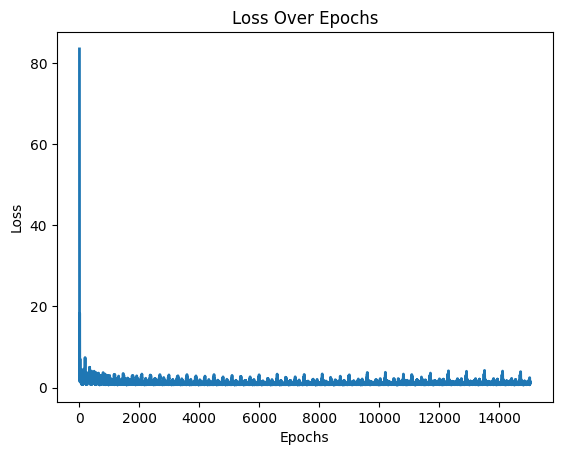

In [61]:
fig, ax = plt.subplots()
# ax.set_facecolor('#E6E6FA')
ax.plot(lyap_loss_values[:],linewidth=2.0, label='Loss')
# ax.grid(True, color='white', linewidth=1)

ax.set_title('Loss Over Epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
# ax.legend()
plt.show()

Calculating the derivative of a Lyapunov function.

In [62]:
lyap_dot_label_list, input_features_list = cwp.calc_lyap_value_nn(
            stateData_all = stateData_all
        )
# print(lyap_dot_label_list)

Learning the D-function by fitting the derivative of the Lyapunov function

In [63]:
DFunction_now = dNet().to(device)

optimizer_dfunc = torch.optim.Adam(DFunction_now.parameters(),lr =0.001,betas = (0.9,0.999),foreach=False)

model_loss, test_loss= cwp.train_d_function(
        train_epoch = 500,
        input_features_list = input_features_list,
        lyap_dot_label_list = lyap_dot_label_list,
        stateData_all = stateData_all
    )

100%|██████████| 500/500 [10:56<00:00,  1.31s/it]


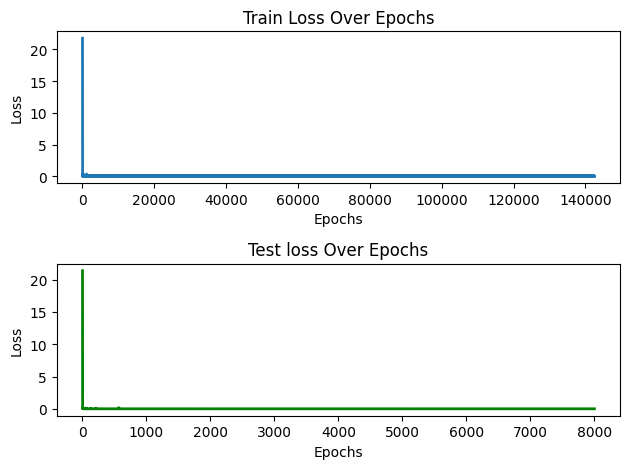

In [64]:
# fig, ax = plt.subplots()
# ax.set_facecolor('#E6E6FA')
plt.subplot(2, 1, 1)
plt.plot(model_loss[:],linewidth=2.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss Over Epochs')
plt.subplot(2, 1, 2)
plt.plot(test_loss[:],'g-', linewidth=2.0,label='phi*a')
plt.title('Test loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.tight_layout()
# plt.savefig('d func loss.svg')
plt.show()

Learning the controller and save the model in the folder `./models/` .

In [65]:
ControllerNet_now = ufunc().to(device)

optimizer_ufunc = torch.optim.Adam(ControllerNet_now.parameters(),lr =0.001,betas = (0.9,0.999),foreach=False)

u_train_loss = cwp.train_cwp_controller(
        train_epoch = 50,
        input_features_list = input_features_list,
        lyap_dot_label_list = lyap_dot_label_list,
        stateData_all = stateData_all
    )

cwp.save_model('./models/')

100%|██████████| 50/50 [31:07<00:00, 37.35s/it]


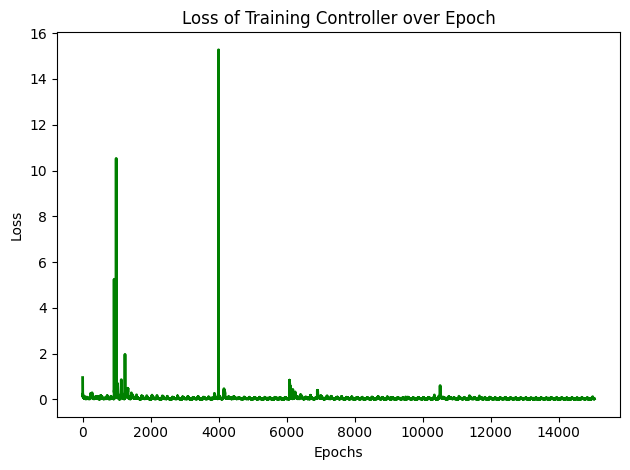

In [66]:

plt.plot(u_train_loss[:],'g-', linewidth=2.0,label='phi*a')
plt.title('Loss of Training Controller over Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.tight_layout()

plt.show()
cwp.save_model('./models/')

## Online D-learning: DL-Clip and DL-Online

Randomly selected initial points for iterative training

In [67]:
def init_pos_random(sample_num : int):
    sample_init_pos = []
    init_pos_y = -11.0
    init_pos_x = -5.0
    data_index = 0

    sample_array = np.random.choice(np.arange(1, 301), size=sample_num, replace=False)

    while data_index <= 300:
        if data_index <= 40:
            init_pos_x = init_pos_x - 0.2
        elif data_index > 40 and data_index <= 150:
            init_pos_y = init_pos_y + 0.2
        elif data_index > 150 and data_index <= 190:
            init_pos_x = init_pos_x + 0.2
        else:
            init_pos_y = init_pos_y - 0.2
        
        data_index = data_index + 1
        if np.isin(data_index, sample_array):
            sample_init_pos.append([init_pos_x, init_pos_y])
    sample_init_pos = np.array(sample_init_pos)
    np.savetxt('sample_init_data.csv',sample_init_pos,fmt="%f",delimiter=',')

In [27]:
init_pos_random(sample_num = 10)

In [ ]:
# Load Pre-trained Controller and D-function
cwp.load_model('./models/')

lyap_loss_list = np.array([])
model_loss_list = np.array([])
u_train_loss_list = np.array([])
# Determining whether RflySim-based sampling is complete or not
is_sample_end_path = 'D:\\Dlearning_PPO\\result\\is_sample_end.txt'
# Determining whether the data feature extraction based on deep metric learning is complete or not
is_metric_end_path = 'D:\\Dlearning_PPO\\result\\is_metric_end.txt'

iteration = 0
max_iterations = 20

while iteration < max_iterations:
    # init_pos_random(sample_num = 10)

    # Sampling step
    os.system('start "RflySimStart" "D:\\Dlearning_PPO\\Bats\\CrossRing3SITL.bat"')
    time.sleep(10)
    os.system('start "Sample" "D:\\Dlearning_PPO\\Bats\\SampleData.bat"')
    while not os.path.exists(is_sample_end_path):
        continue
    if os.path.exists(is_sample_end_path):
        print("Sample "+ str(iteration) + " end")
        os.remove(is_sample_end_path)
        HIL_disconnect()
        time.sleep(5)

    # Feature extraction step
    os.system('start "ImageToMetric" "D:\\Dlearning_PPO\\Bats\\ImageToMetric.bat"')
    while not os.path.exists(is_metric_end_path):
        continue
    if os.path.exists(is_metric_end_path):
        print("Image to Metric Encoding "+ str(iteration) + " end")
        os.remove(is_metric_end_path)
        send_to_window("ImageToMetric", 'dir')
        time.sleep(6)

    stateData_all = []
    # Load flight data from sample trajectories
    files = os.listdir(metric_parent)
    files = sorted(files, key=lambda x: os.path.getmtime(os.path.join(metric_parent, x)))
    metric_dataset_dir = metric_parent + files[-1]
    for i in range(len(os.listdir(metric_dataset_dir))):
        filename =  metric_dataset_dir + '/cwp_dataengine_{}.csv'.format(str(i))
        if not os.path.exists(filename):
            break
        stateDataAll1 = np.loadtxt(open(filename,"rb"),delimiter=",",skiprows=1)
        stateData_all.append(stateDataAll1)


    # The epoch of each training step
    epoch_per_iter = 1

    # Training Lyapunov function
    lyap_loss_values = cwp.learn_V_LNN(
        train_epoch = epoch_per_iter,
        stateData_all = stateData_all
    )
    # print(np.mean(lyap_loss_values))
    lyap_loss_list = np.append(lyap_loss_list, lyap_loss_values)
    # print(lyap_loss_list.shape)
    lyap_dot_label_list, input_features_list = cwp.calc_lyap_value_nn(
            stateData_all = stateData_all
        )
    
    # Training D-function
    model_loss, test_loss= cwp.train_d_function(
        train_epoch = epoch_per_iter,
        input_features_list = input_features_list,
        lyap_dot_label_list = lyap_dot_label_list,
        stateData_all = stateData_all
    )

    # print(np.mean(model_loss))
    model_loss_list = np.append(model_loss_list, model_loss)
    # print(model_loss_list.shape)

    # Training DL-Clip
    u_train_loss = cwp.train_cwp_ppo_controller(
        train_epoch = epoch_per_iter,
        input_features_list = input_features_list,
        lyap_dot_label_list = lyap_dot_label_list,
        stateData_all = stateData_all
    )
    # print(np.mean(u_train_loss))
    u_train_loss_list = np.append(u_train_loss_list, u_train_loss)
    # print(u_train_loss_list.shape)
    
    iteration = iteration + 1
    
    # Save the model trained in each iteration
    if not os.path.exists('./models_{}/'.format(str(iteration))):
        os.makedirs('./models_{}/'.format(str(iteration)))
    cwp.save_model('./models_{}/'.format(str(iteration)))

## Training results

Includes controller performance comparisons and iterative performance change curves

flight_data_metric_2024-08-23_12-59-54 252.0
flight_data_metric_2024-08-23_12-56-12 268.2
flight_data_metric_2024-08-23_12-52-29 273.0
flight_data_metric_2024-08-23_12-48-43 279.4
flight_data_metric_2024-08-23_12-44-54 286.7
flight_data_metric_2024-08-23_12-41-01 298.0
flight_data_metric_2024-08-23_12-37-05 304.6
flight_data_metric_2024-08-23_12-33-06 312.2
flight_data_metric_2024-08-23_12-29-01 326.4
flight_data_metric_2024-08-23_12-24-53 335.6
flight_data_metric_2024-08-23_12-20-41 346.9
flight_data_metric_2024-08-23_12-16-14 381.0
flight_data_metric_2024-08-23_12-11-48 381.0
flight_data_metric_2024-08-23_12-07-17 389.9
flight_data_metric_2024-08-23_12-02-42 403.7
flight_data_metric_2024-08-23_11-57-56 428.5
flight_data_metric_2024-08-23_11-53-04 444.7
flight_data_metric_2024-08-23_11-47-28 551.1
flight_data_metric_2024-08-23_17-31-24 664.8
flight_data_metric_2024-08-23_17-25-49 553.5
flight_data_metric_2024-08-23_17-19-29 667.4
flight_data_metric_2024-08-23_17-14-02 534.7
flight_dat

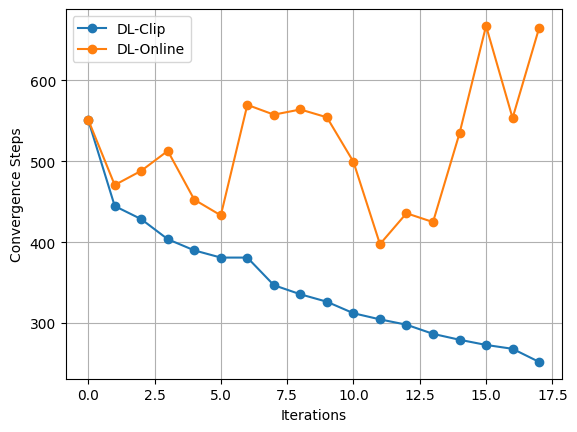

In [34]:
# DL-Online Iteration Dataset
output_parent = './DL-Clip_dataset/'

output_files = os.listdir(output_parent)
output_files = sorted(output_files, key=lambda x: os.path.getmtime(os.path.join(output_parent, x)))
output_files = output_files[::-1] # Depends on when the data was created
length_array = np.zeros((18))
j = 17

for output_file in output_files:
    output_dataset_dir = output_parent + output_file
    len_sum = 0.0
    for i in range(10):
        filename =  output_dataset_dir + '/cwp_dataengine_{}.csv'.format(str(i))
        if not os.path.exists(filename):
            break
        stateDataAll1 = np.loadtxt(open(filename,"rb"),delimiter=",",skiprows=1)
        len_sum = len_sum + len(stateDataAll1)
    print(output_file, len_sum / 10.0 )
    length_array[j] = len_sum / 10.0
    j = j - 1
plt.plot(length_array,marker='o',label='DL-Clip')

# DL-Online Iteration Dataset
output_parent = './DL-Online_dataset/'

output_files = os.listdir(output_parent)
output_files = sorted(output_files, key=lambda x: os.path.getmtime(os.path.join(output_parent, x)))
output_files = output_files[::-1] # Depends on when the data was created
length_array = np.zeros((18))
j = 17

for output_file in output_files:
    output_dataset_dir = output_parent + output_file
    len_sum = 0.0
    for i in range(10):
        filename =  output_dataset_dir + '/cwp_dataengine_{}.csv'.format(str(i))
        if not os.path.exists(filename):
            break
        stateDataAll1 = np.loadtxt(open(filename,"rb"),delimiter=",",skiprows=1)
        len_sum = len_sum + len(stateDataAll1)
    print(output_file, len_sum / 10.0 )
    length_array[j] = len_sum / 10.0
    j = j - 1
plt.plot(length_array, marker='o', label='DL-Online')
# plt.title('Convergence Steps over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Convergence Steps')


plt.grid(True)


# plt.legend()
plt.legend()
# plt.savefig('Convergence Steps over Iterations.png', dpi=1500)
plt.show()